In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import grangercausalitytests

from utils import *
from pair_trading import PairSelector, Backtester, ParameterTuner, PairTrading

from IPython.display import display, Markdown
import warnings
warnings.filterwarnings('ignore') 

## Load Data

In [2]:
sp500_tickers = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]['Symbol'].tolist()
sp500_tickers.append('^GSPC')
start_date = '2012-01-01'
end_date = '2017-12-31'

data = yf.download(sp500_tickers, start=start_date, end=end_date)['Adj Close']
data = data.dropna(axis=1)
data = data.reset_index()
data.columns = list(data.columns)

[*********************100%***********************]  504 of 504 completed

24 Failed downloads:
['MRNA', 'CTVA', 'FOXA', 'OTIS', 'DOW', 'CRWD', 'KVUE', 'SW', 'ABNB', 'CEG', 'VLTO', 'SOLV', 'VICI', 'GEHC', 'UBER', 'GEV', 'FOX', 'CARR', 'DAY']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2012-01-01 -> 2017-12-31) (Yahoo error = "Data doesn\'t exist for startDate = 1325394000, endDate = 1514696400")')
['FITB', 'TECH', 'DXCM']: ReadTimeout(ReadTimeoutError("HTTPSConnectionPool(host='query2.finance.yahoo.com', port=443): Read timed out. (read timeout=10)"))
['BF.B']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2012-01-01 -> 2017-12-31)')
['BRK.B']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


In [3]:
test_data = yf.download(sp500_tickers, start='2018-01-01', end='2019-12-31')['Adj Close']
test_data = test_data.dropna(axis=1)
test_data = test_data.reset_index()
test_data.columns = list(test_data.columns)

[*********************100%***********************]  504 of 504 completed

12 Failed downloads:
['OTIS', 'KVUE', 'SW', 'CEG', 'ABNB', 'VLTO', 'SOLV', 'GEHC', 'GEV', 'CARR']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2018-01-01 -> 2019-12-31) (Yahoo error = "Data doesn\'t exist for startDate = 1514782800, endDate = 1577768400")')
['BF.B']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2018-01-01 -> 2019-12-31)')
['BRK.B']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


## Modelling and Simulation

In [4]:
method_best_pair = {}
for method in ['corr', 'ADF', 'Granger', 'distance']:
    pair_selector = PairSelector(data)
    pair_score = pair_selector.get_pairs_with_score(method=method)
    top_pair = top_n_elements(pair_score, 10)
    tuner = ParameterTuner(data, top_pair.keys())
    best_param = tuner.choose_parameters()
    method_best_pair[method] = best_param
    print(f'{method} selection successfully done')

corr selection successfully done
ADF selection successfully done
Granger selection successfully done
distance selection successfully done


In [5]:
for method in ['corr', 'ADF', 'Granger', 'distance']:
    pair_trading = PairTrading(method_best_pair[method], data)
    display(Markdown(f'**In-sample Strategy Summary for {method} Selected Pairs**'))
    pair_trading.calculate_pnl()
    pair_trading.strategy_perf()

**In-sample Strategy Summary for corr Selected Pairs**

,security_0,security_1,PnL,Sharpe,Turnover,Trade Duration,return
0,GOOG,GOOGL,41069.320044,1.080295,20.842807,2.967742,0.006858
1,CMS,XEL,219337.659086,1.766243,43.565525,3.648438,0.036629
2,WEC,XEL,111365.101496,0.734366,8.499873,10.080000,0.018598
3,CMS,DTE,191586.816521,0.986754,14.133116,9.585366,0.031995
4,AVB,EQR,251669.600698,0.550753,15.458498,21.340909,0.042028
5,MET,PRU,27691.410736,0.096504,8.360897,19.625000,0.004624
6,CMS,WEC,141638.029730,0.990024,16.183611,7.541667,0.023653
7,DTE,XEL,239850.912525,0.963316,25.678590,6.880000,0.040055
8,PNW,XEL,267879.532587,1.005780,16.132022,14.106383,0.044735
9,LNT,XEL,135467.561798,0.966994,8.922498,14.846154,0.022623


,ann_ret,sharpe,turnover,average duration
0,0.02718,1.979041,17.777744,8.909615


**In-sample Strategy Summary for ADF Selected Pairs**

,security_0,security_1,PnL,Sharpe,Turnover,Trade Duration,return
0,JKHY,MAS,9.151926e+04,0.263492,13.250645,6.564103,0.015284
1,HUM,NXPI,1.004782e+06,1.011255,18.926325,15.584906,0.167797
2,AVY,MAS,7.976756e+05,0.875135,15.152193,29.700000,0.133210
3,BDX,CRL,3.056140e+05,0.594835,20.306975,11.482143,0.051037
4,ADP,IT,3.278414e+05,0.936264,12.069678,10.529412,0.054749
5,CRL,CRM,4.079202e+05,0.641041,42.496379,4.339130,0.068122
6,IT,MMC,4.026600e+05,0.852954,26.639111,6.459459,0.067243
7,APH,MMM,3.516899e+05,0.535548,29.558982,16.567164,0.058732
8,ADP,CRM,1.881007e+05,0.496564,11.746493,10.088235,0.031412
9,CRM,RVTY,9.496879e+05,1.229891,7.954860,26.478261,0.158596


,ann_ret,sharpe,turnover,average duration
0,0.080618,2.343933,19.810164,11.794393


**In-sample Strategy Summary for Granger Selected Pairs**

,security_0,security_1,PnL,Sharpe,Turnover,Trade Duration,return
0,NEE,SWK,3.015098e+05,0.400106,15.927530,38.133333,0.050352
1,DD,KLAC,7.644575e+05,0.987409,33.793631,9.551724,0.127663
2,ROL,WAT,5.567075e+05,0.985293,28.099851,5.493151,0.092969
3,BKNG,MA,6.066179e+05,1.046474,10.223533,7.500000,0.101304
4,A,MA,6.564377e+05,0.959790,34.408745,9.395349,0.109624
5,PKG,WTW,2.171377e+05,0.520374,12.055547,11.242424,0.036262
6,NEE,ROP,3.434579e+05,0.898766,8.871459,10.880000,0.057357
7,EA,VRSN,4.581858e+04,0.062911,7.242961,29.111111,0.007652
8,EXPE,TYL,1.611455e+06,1.153257,25.326787,17.967742,0.269110
9,GPN,UNH,1.550876e+05,0.227402,8.374096,42.250000,0.025899


,ann_ret,sharpe,turnover,average duration
0,0.087819,2.228166,18.432414,14.084052


**In-sample Strategy Summary for distance Selected Pairs**

,security_0,security_1,PnL,Sharpe,Turnover,Trade Duration,return
0,GOOG,GOOGL,41069.320044,1.080295,20.842807,2.967742,0.006858
1,AVB,EQR,251669.600698,0.550753,15.458498,21.340909,0.042028
2,FRT,SPG,300459.206890,1.359030,8.643021,14.360000,0.050176
3,LNT,WEC,97559.975391,0.606331,7.294488,15.000000,0.016292
4,ES,PEP,234049.145889,0.711279,10.067608,11.571429,0.039086
5,CB,JNJ,245510.198170,1.248900,6.362766,9.368421,0.041000
6,AEP,ES,286898.628464,1.162314,30.826400,8.977273,0.047912
7,AEP,WEC,169992.144005,0.539574,13.642118,31.135135,0.028388
8,D,UPS,333335.866627,0.616108,12.330297,36.178571,0.055666
9,CB,DTE,562694.728708,1.208567,7.573753,35.761905,0.093969


,ann_ret,sharpe,turnover,average duration
0,0.042138,2.181277,13.304176,16.099196


In [6]:
for method in ['corr', 'ADF', 'Granger', 'distance']:
    test_trading = PairTrading(method_best_pair[method], test_data)
    display(Markdown(f'**Out-of-sample Strategy Summary for {method} Selected Pairs**'))
    test_trading.calculate_pnl()
    test_trading.strategy_perf()

**Out-of-sample Strategy Summary for corr Selected Pairs**

,security_0,security_1,PnL,Sharpe,Turnover,Trade Duration,return
0,GOOG,GOOGL,14125.520927,1.282512,17.774504,3.000000,0.007091
1,CMS,XEL,45679.466324,1.033947,34.937605,4.000000,0.022931
2,WEC,XEL,-16543.652248,-0.492707,5.068067,12.200000,-0.008305
3,CMS,DTE,-41053.019222,-0.636132,9.481740,13.888889,-0.020608
4,AVB,EQR,138873.504299,0.970948,16.172390,18.437500,0.069713
5,MET,PRU,-84228.082474,-0.867560,8.216521,22.625000,-0.042282
6,CMS,WEC,25674.912880,0.850179,15.341354,6.266667,0.012889
7,DTE,XEL,15856.105835,0.172522,24.822311,7.250000,0.007960
8,PNW,XEL,128502.262562,1.204180,12.375830,15.000000,0.064507
9,LNT,XEL,-602.104454,-0.013766,6.830903,22.857143,-0.000302


,ann_ret,sharpe,turnover,average duration
0,0.011359,0.815811,15.102123,9.864865


**Out-of-sample Strategy Summary for ADF Selected Pairs**

,security_0,security_1,PnL,Sharpe,Turnover,Trade Duration,return
0,JKHY,MAS,-10788.369184,-0.085230,8.214979,7.125000,-0.005416
1,HUM,NXPI,-199907.918213,-0.502101,15.641724,26.538462,-0.100352
2,AVY,MAS,222730.000471,0.788227,14.162953,19.923077,0.111809
3,BDX,CRL,73501.158081,0.406880,19.408919,12.722222,0.036897
4,ADP,IT,137347.449654,1.482503,7.319329,8.857143,0.068947
5,CRL,CRM,-119839.832565,-0.593941,37.714627,5.147059,-0.060159
6,IT,MMC,-184374.728493,-1.018899,25.375598,10.000000,-0.092555
7,APH,MMM,74086.992310,0.225261,31.808451,16.083333,0.037191
8,ADP,CRM,28329.077682,0.187377,8.673838,16.375000,0.014221
9,CRM,RVTY,323072.924217,1.489250,6.163729,24.833333,0.162180


,ann_ret,sharpe,turnover,average duration
0,0.017276,0.38422,17.448415,13.136364


**Out-of-sample Strategy Summary for Granger Selected Pairs**

,security_0,security_1,PnL,Sharpe,Turnover,Trade Duration,return
0,NEE,SWK,-26913.639889,-0.102828,13.943457,35.900000,-0.013510
1,DD,KLAC,228198.580307,0.795021,29.841584,10.320000,0.114554
2,ROL,WAT,-57845.475643,-0.284983,23.118692,7.473684,-0.029038
3,BKNG,MA,150385.834900,0.871025,9.250591,9.111111,0.075492
4,A,MA,-55541.530769,-0.227167,26.629085,12.300000,-0.027881
5,PKG,WTW,-90400.679207,-0.679302,7.890859,8.714286,-0.045380
6,NEE,ROP,-42974.868458,-0.274016,4.463553,24.000000,-0.021573
7,EA,VRSN,-101326.750549,-0.421103,4.589285,41.666667,-0.050865
8,EXPE,TYL,14456.490158,0.051244,20.809204,20.750000,0.007257
9,GPN,UNH,86528.061745,0.510317,4.171576,34.000000,0.043436


,ann_ret,sharpe,turnover,average duration
0,0.005249,0.130688,14.470789,15.700855


**Out-of-sample Strategy Summary for distance Selected Pairs**

,security_0,security_1,PnL,Sharpe,Turnover,Trade Duration,return
0,GOOG,GOOGL,14125.520927,1.282512,17.774504,3.000000,0.007091
1,AVB,EQR,138873.504299,0.970948,16.172390,18.437500,0.069713
2,FRT,SPG,34981.880806,0.499686,8.121017,16.125000,0.017561
3,LNT,WEC,23132.203308,0.487375,8.943865,17.444444,0.011612
4,ES,PEP,-8974.318039,-0.095206,9.373021,11.888889,-0.004505
5,CB,JNJ,79653.486893,0.903584,4.339506,11.750000,0.039985
6,AEP,ES,160353.694084,2.484537,28.890247,7.571429,0.080496
7,AEP,WEC,-588.456509,-0.007665,11.567855,31.363636,-0.000295
8,D,UPS,45440.313908,0.195733,13.415901,33.545455,0.022811
9,CB,DTE,111152.675339,0.806689,4.367972,37.000000,0.055798


,ann_ret,sharpe,turnover,average duration
0,0.030027,1.65866,12.296628,15.788136


In [7]:
all_data = pd.concat([data, test_data]).reset_index(drop=True)
all_data = all_data.dropna(axis=1)
pairs = list(method_best_pair['distance'])
performance = pd.DataFrame(np.zeros((all_data.shape[0], len(pairs))), columns=pairs)
for pair in pairs:
    params = method_best_pair['distance'][pair]
    backtester = Backtester(all_data, pair[0], pair[1])
    backtester.simulate(window=params[0], open_score=params[1], close_score=params[2])
    backtester.get_result()
    performance[pair] = backtester.result['daily_ret']
performance['daily_ret'] = performance.mean(axis=1)
performance['cum_ret'] = performance['daily_ret'].cumsum()

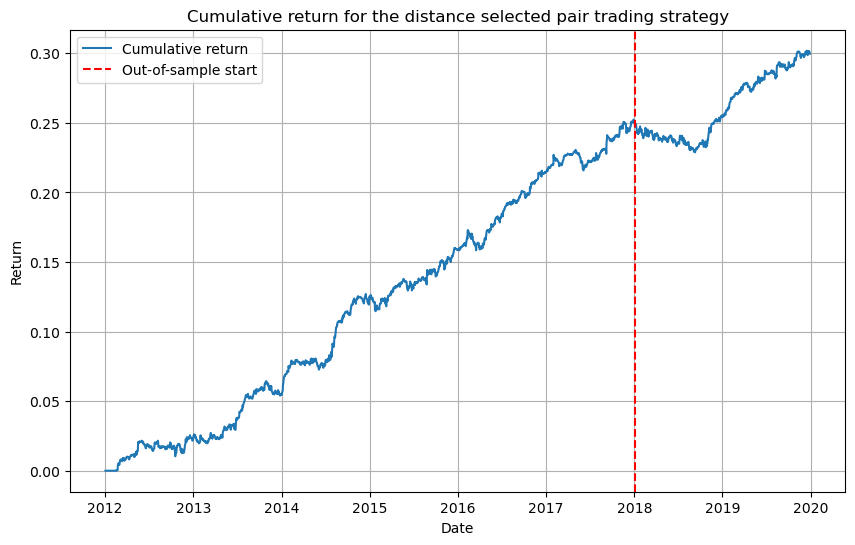

In [8]:
plt.figure(figsize=(10, 6))
plt.plot(all_data['Date'], performance['cum_ret'], label='Cumulative return')
plt.title('Cumulative return for the distance selected pair trading strategy')
plt.axvline(x=test_data['Date'].min(), color='red', linestyle='--', label='Out-of-sample start')
plt.grid(True)
plt.legend()
plt.xlabel('Date')
plt.ylabel('Return')
plt.show()

## Sensitivity Test

In [9]:
class SensitivityTest:
    def __init__(self, best_param, data):
        self.best_param = best_param
        self.data = data
    
    def window_test(self):
        rslt = []
        for change in [-0.2, -0.1, -0.05, 0, 0.05, 0.1, 0.2]:
            test = {}
            for pair in self.best_param:
                test[pair] = (int(self.best_param[pair][0] * (1 + change)), 
                              self.best_param[pair][1], self.best_param[pair][2])
            pair_trading = PairTrading(test, self.data)
            sharpe = pair_trading.get_sharpe()
            rslt.append(sharpe)
        return rslt
    
    def open_test(self):
        rslt = []
        for change in [-0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6]:
            test = {}
            for pair in self.best_param:
                test[pair] = (self.best_param[pair][0], 
                              self.best_param[pair][1] + change, self.best_param[pair][2])
            pair_trading = PairTrading(test, self.data)
            sharpe = pair_trading.get_sharpe()
            rslt.append(sharpe)
        return rslt
    
    def close_test(self):
        rslt = []
        for change in [-0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6]:
            test = {}
            for pair in self.best_param:
                test[pair] = (self.best_param[pair][0], 
                              self.best_param[pair][1], self.best_param[pair][2] + change)
            pair_trading = PairTrading(test, self.data)
            sharpe = pair_trading.get_sharpe()
            rslt.append(sharpe)
        return rslt

In [10]:
rslt_window = {}
rslt_open = {}
rslt_close = {}
for method in ['corr', 'ADF', 'Granger', 'distance']:
    sensitivity_test = SensitivityTest(method_best_pair[method], data)
    rslt_window[method] = sensitivity_test.window_test()
    rslt_open[method] = sensitivity_test.open_test()
    rslt_close[method] = sensitivity_test.close_test()

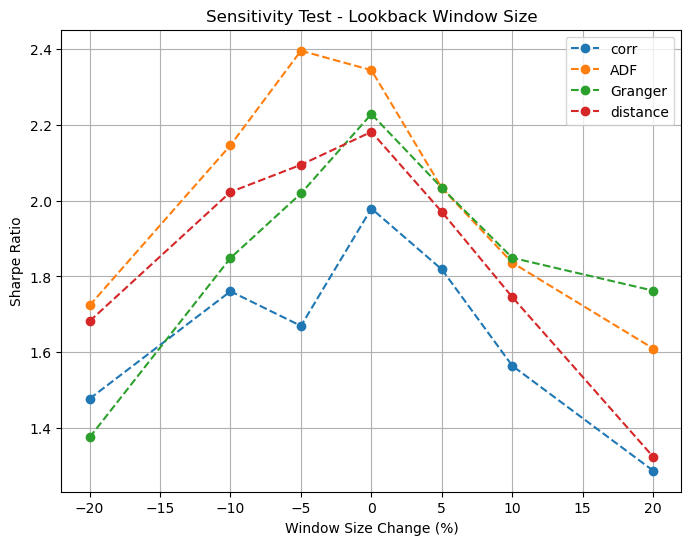

In [11]:
plt.figure(figsize=(8, 6))
plt.title('Sensitivity Test - Lookback Window Size')
change = np.array([-0.2, -0.1, -0.05, 0, 0.05, 0.1, 0.2])
for method in ['corr', 'ADF', 'Granger', 'distance']:
    plt.plot(change * 100, rslt_window[method], linestyle='--', marker='o', label=method)
plt.ylabel('Sharpe Ratio')
plt.xlabel('Window Size Change (%)')
plt.grid(True)
plt.legend()
plt.show()

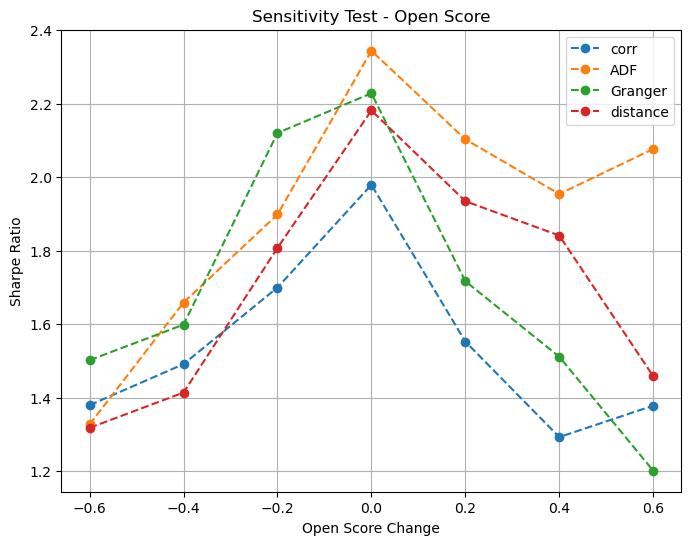

In [12]:
plt.figure(figsize=(8, 6))
plt.title('Sensitivity Test - Open Score')
change = np.array([-0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6])
for method in ['corr', 'ADF', 'Granger', 'distance']:
    plt.plot(change, rslt_open[method], linestyle='--', marker='o', label=method)
plt.ylabel('Sharpe Ratio')
plt.xlabel('Open Score Change')
plt.grid(True)
plt.legend()
plt.show()

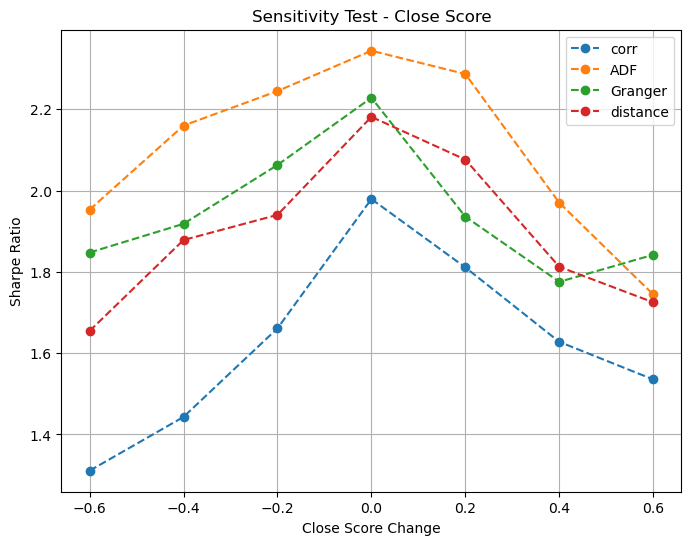

In [13]:
plt.figure(figsize=(8, 6))
plt.title('Sensitivity Test - Close Score')
change = np.array([-0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6])
for method in ['corr', 'ADF', 'Granger', 'distance']:
    plt.plot(change, rslt_close[method], linestyle='--', marker='o', label=method)
plt.ylabel('Sharpe Ratio')
plt.xlabel('Close Score Change')
plt.grid(True)
plt.legend()
plt.show()

In [14]:
rslt_window_oos = {}
rslt_open_oos = {}
rslt_close_oos = {}
for method in ['corr', 'ADF', 'Granger', 'distance']:
    sensitivity_test = SensitivityTest(method_best_pair[method], test_data)
    rslt_window_oos[method] = sensitivity_test.window_test()
    rslt_open_oos[method] = sensitivity_test.open_test()
    rslt_close_oos[method] = sensitivity_test.close_test()

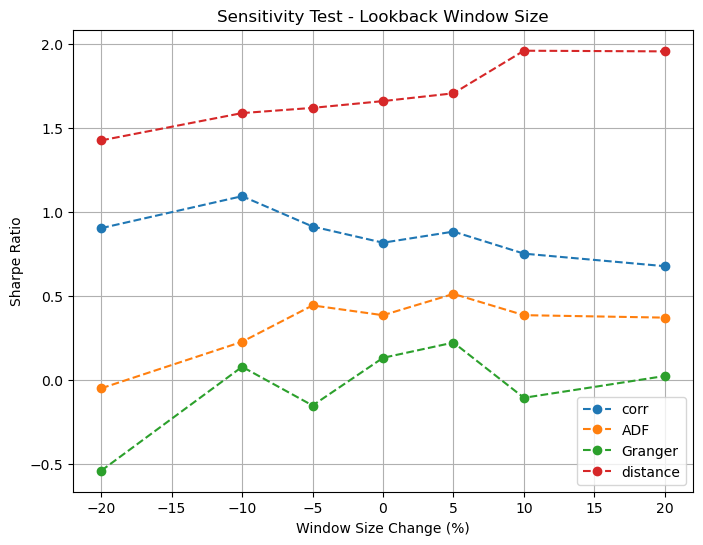

In [15]:
plt.figure(figsize=(8, 6))
plt.title('Sensitivity Test - Lookback Window Size')
change = np.array([-0.2, -0.1, -0.05, 0, 0.05, 0.1, 0.2])
for method in ['corr', 'ADF', 'Granger', 'distance']:
    plt.plot(change * 100, rslt_window_oos[method], linestyle='--', marker='o', label=method)
plt.ylabel('Sharpe Ratio')
plt.xlabel('Window Size Change (%)')
plt.grid(True)
plt.legend()
plt.show()

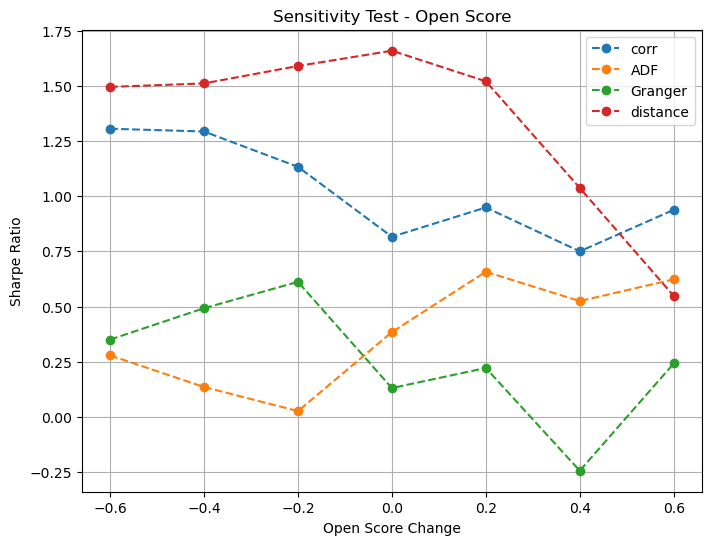

In [16]:
plt.figure(figsize=(8, 6))
plt.title('Sensitivity Test - Open Score')
change = np.array([-0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6])
for method in ['corr', 'ADF', 'Granger', 'distance']:
    plt.plot(change, rslt_open_oos[method], linestyle='--', marker='o', label=method)
plt.ylabel('Sharpe Ratio')
plt.xlabel('Open Score Change')
plt.grid(True)
plt.legend()
plt.show()

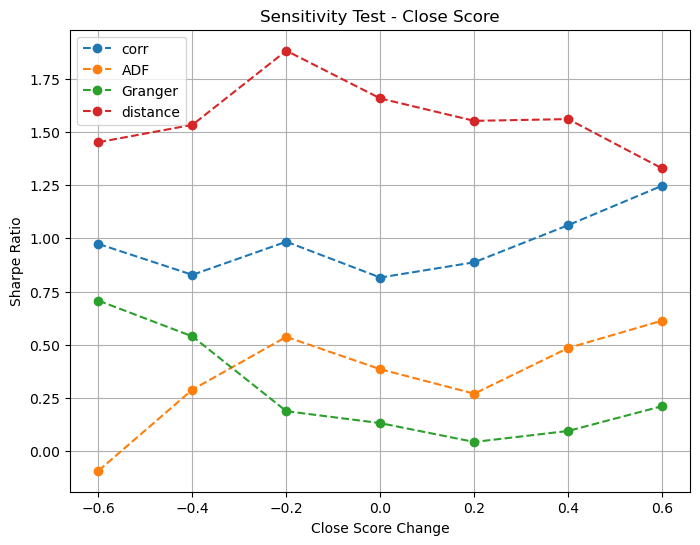

In [17]:
plt.figure(figsize=(8, 6))
plt.title('Sensitivity Test - Close Score')
change = np.array([-0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6])
for method in ['corr', 'ADF', 'Granger', 'distance']:
    plt.plot(change, rslt_close_oos[method], linestyle='--', marker='o', label=method)
plt.ylabel('Sharpe Ratio')
plt.xlabel('Close Score Change')
plt.grid(True)
plt.legend()
plt.show()

In [18]:
trades = []
for method in method_best_pair:
    for pair in method_best_pair[method]:
        params = method_best_pair[method][pair]
        backtester = Backtester(data, pair[0], pair[1])
        backtester.simulate(window=params[0], open_score=params[1], close_score=params[2])
        backtester.get_result()
        trades.append(backtester.get_agg_trades())
trades = pd.concat(trades)

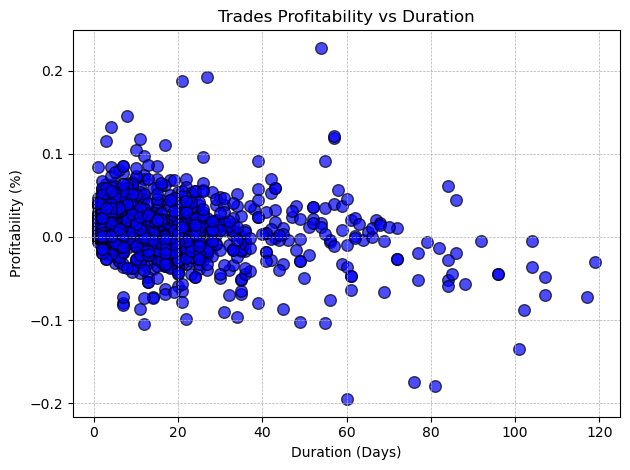

In [19]:
plt.scatter(trades['Date'], trades['next_ret'], color='blue', edgecolor='k', s=70, alpha=0.7)
plt.title('Trades Profitability vs Duration')
plt.xlabel('Duration (Days)')
plt.ylabel('Profitability (%)')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

In [20]:
print(f'the correlation between trades duration and prifitability is {round(trades.corr().iloc[0, 1], 2)}')

the correlation between trades duration and prifitability is -0.22
